# Sinogram Denoiser (Sinusoidal Patching) Using PET-Brainweb Images

In [1]:
# to find and check the hardware(GPU) situatuion, if you have no available GPUs, please no worries. This neural netwaork can run via CPU.
import torch
print(torch.cuda.is_available())  # to find available GPUs
print(torch.cuda.device_count()) # to count the number of GPUs
print(torch.cuda.get_device_name(0))  # To get name of the first available GPU
print(torch.__version__)

True
1
NVIDIA GeForce RTX 4070 SUPER
2.4.1+cu124


In [2]:
import os

original_path = os.environ.get("PATH")
custom_path = r"C:\Users\47348\anaconda3\envs\reconstruction\Library\bin"
os.environ["PATH"] = f"{custom_path};{original_path}"
# os.environ['PARALLELPROJ_C_LIB'] = r"C:\Users\47348\anaconda3\envs\reconstruction\Library\bin\parallelproj_c.dll"
# os.environ['PARALLELPROJ_CUDA_LIB'] = r"C:\Users\47348\anaconda3\envs\reconstruction\Library\bin\parallelproj_cuda.dll"

In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import warnings
warnings.filterwarnings('ignore')

import odl
import odlpet
from odlpet.scanner.scanner import Scanner
from odlpet.scanner.compression import Compression
from odl.contrib.torch import OperatorModule
from odl.contrib import fom


import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.nn.parallel import DataParallel as DP
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR
torch.backends.cudnn.benchmark = True
from torch.utils.data import DataLoader, TensorDataset


import parallelproj
from torchProjectionLayer import LinearSingleChannelOperator
from torchProjectionLayer import AdjointLinearSingleChannelOperator
from array_api_compat import to_device
#from array_api_compat import device
import array_api_compat.torch as xp

#import parallelproj

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0) # modified


              -  -  -  -  -  -  -  -   -  -  -  -
              P  A  R  A  L  L  E  L | P  R  O  J
              -  -  -  -  -  -  -  -   -  -  -  -


             Please consider citing our publication
          ---------------------------------------------
          Georg Schramm and Kris Thielemans:
          "PARALLELPROJ—an open-source framework for
           fast calculation of projections in
           tomography"
          Front. Nucl. Med., 08 January 2024
          Sec. PET and SPECT, Vol 3
          https://doi.org/10.3389/fnume.2023.1324562

 
        parallelproj C    lib         ..: C:\Users\47348\anaconda3\envs\reconstruction\Library\bin\parallelproj_c.dll
        parallelproj CUDA lib         ..: C:\Users\47348\anaconda3\envs\reconstruction\Library\bin\parallelproj_cuda.dll
        parallelproj CUDA kernel file ..: C:\Users\47348\anaconda3\envs\reconstruction\Library\lib\projector_kernels.cu.1.10.0
        parallelproj CUDA present     ..: True
        parallelproj c

In [4]:
# Load the training noisy and noisefree sinograms
sinograms_noisy = np.load(r'./PET_data/Train_npy/training_sinograms_noisy.npy')
sinograms_noisefree = np.load(r'./PET_data/Train_npy/training_sinograms_noisefree.npy')

# Convert the numpy arrays to PyTorch tensors
sinograms_noisy = torch.tensor(sinograms_noisy, dtype=torch.float32)
sinograms_noisefree = torch.tensor(sinograms_noisefree, dtype=torch.float32)

# Create a custom dataset
class SinogramDataset(Dataset):
    def __init__(self, noisy, noisefree):
        self.noisy = noisy
        self.noisefree = noisefree

    def __len__(self):
        return self.noisy.shape[0]  # Total number of sinogram sets

    def __getitem__(self, idx):
        return self.noisy[idx], self.noisefree[idx]

# Create a dataset and data loader with batch_size=1 (processing one sinogram set at a time)
dataset = SinogramDataset(sinograms_noisy, sinograms_noisefree)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # Use batch_size=1

In [5]:
num_rings = 35
scanner = parallelproj.RegularPolygonPETScannerGeometry(
    xp,
    dev,
    radius= 211/2 - 2,
    num_sides=12,
    num_lor_endpoints_per_side= 35,
    lor_spacing= 211*np.pi/(35*12),
    ring_positions=xp.linspace(-20, 20, num_rings),
    #ring_positions=torch.linspace(-25, 25, num_rings),
    symmetry_axis=1,
)

lor_desc = parallelproj.RegularPolygonPETLORDescriptor(
    scanner,
    radial_trim=155,
    max_ring_difference=0,
    sinogram_order=parallelproj.SinogramSpatialAxisOrder.RVP,
)


proj = parallelproj.RegularPolygonPETProjector(
    lor_desc, img_shape=(220, num_rings, 220), voxel_size=(80/220, 40/num_rings, 80/220)
)

In [6]:
res_model = parallelproj.GaussianFilterOperator(
    proj.in_shape, sigma=0.75 / (2.35 * proj.voxel_size)
)

In [7]:
import torch.nn.functional as F

def get_indices(patch_size, s=0, dev='cuda'):
    
    image_shape = (220, 220)

    num_patches_grid = (int(np.ceil(image_shape[0]/patch_size[0])), int(np.ceil(image_shape[1]/patch_size[1])))
    images = np.zeros((num_patches_grid[0]*num_patches_grid[1], image_shape[0], image_shape[1]))
    indices = []

    num_patches = num_patches_grid[0]*num_patches_grid[1]
    for k in range(num_patches):
        i = k // num_patches_grid[1]
        j = k % num_patches_grid[1]
        images[k, i*patch_size[0]:(i+1)*patch_size[0], j*patch_size[1]:(j+1)*patch_size[1]] = 1
        #plt.imshow(images[k])
        data = proj(torch.tensor(images[k]).unsqueeze(1).repeat(1, 35, 1).to('cuda'))
        index = (data[:,:,0].unsqueeze(0).unsqueeze(1) > s).nonzero()
        indices.append(index)

    lengths = [len(tensor) for tensor in indices]
    max_length = max(lengths)

    padded_tensors = []
    for tensor in indices:
        pad_size = max_length - len(tensor)
        padded_tensor = F.pad(tensor, (0, 0, pad_size, 0))
        padded_tensors.append(padded_tensor)
    
    stacked_tensor = torch.stack(padded_tensors)

    return stacked_tensor.squeeze(0)

In [8]:
indices=get_indices((110, 110), s=0, dev='cuda')
indices.shape

torch.Size([4, 12950, 4])

In [9]:
num_epochs = 10

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class Transformer(nn.Module):
  def __init__(self, head_dim=32, heads=6, dropout=0.3):
    super(Transformer, self).__init__()
    self.head_dim = head_dim
    self.heads = heads
    self.embedding_dim = heads*head_dim
  
    self.softmax = nn.Softmax(dim=-1)
    self.Q = nn.Linear(self.embedding_dim, head_dim*heads, bias=False)
    self.K = nn.Linear(self.embedding_dim, head_dim*heads, bias=False)
    self.V = nn.Linear(self.embedding_dim, head_dim*heads, bias=False)
    
    self.mlp = nn.Sequential(nn.Linear(self.embedding_dim, self.embedding_dim), nn.ReLU(),
                             nn.Linear(self.embedding_dim, self.embedding_dim), nn.ReLU())

    self.layernorm = nn.LayerNorm(heads*head_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self,Z):
    Q, K, V = self.Q(Z), self.K(Z), self.V(Z)
    attention = self.dropout(torch.matmul(self.softmax(torch.matmul(Q, K.transpose(-1, -2)) * self.head_dim ** -0.5),V))
    
    x = self.layernorm(attention+Z)
    x = self.dropout(self.mlp(x))
    return x

class TransformerBlock(nn.Module):
    def __init__(self, in_channels, out_channels, img_shape, indices, head_dim=32, heads=6):
        super(TransformerBlock, self).__init__()

        self.head_dim = head_dim
        self.heads = heads
        self.embedding_dim = heads*head_dim
        self.im_h, self.im_w, self.im_d = img_shape
        self.in_channels = in_channels
        self.indices = indices
        self.num_patches = indices.shape[0]
        self.patch_dim = indices.shape[1]

        self.flatten = Rearrange('b c p v s -> (b s) (c p) v')

        self.H = nn.Sequential(
            nn.Linear(self.patch_dim, self.embedding_dim),
            nn.LayerNorm(self.embedding_dim)
        )

        self.positional_encodings = nn.Parameter(torch.randn(self.num_patches*self.in_channels, self.embedding_dim))

        self.tail = nn.Sequential(nn.Linear(self.embedding_dim, self.patch_dim), 
                                  nn.ReLU(),
                                  Rearrange('(b s) (c p) v -> b c p v s', p = self.num_patches, s=self.im_d))
        
        
        self.residualBlock = nn.Sequential(Rearrange('b c h w s -> (b s) c h w'),
                                           ResidualBlock(in_channels, out_channels),
                                           Rearrange('(b s) c h w -> b c h w s', s=self.im_d))
        
        self.layers = nn.Sequential(Transformer(),Transformer())

    def forward(self, sino):
      #print(sino.shape)
      #sino = sino.unsqueeze(0).unsqueeze(0).unsqueeze(-1)
      sino = sino.unsqueeze(-1)
      encodings = sino[:,:,self.indices[:,:,0],self.indices[:,:,1],:]
      #print(encodings.shape)
      encodings = self.flatten(encodings)
      #print(encodings.shape)
      H = self.H(encodings)
      Z = H + self.positional_encodings.repeat(sino.shape[-1]*sino.shape[0],1,1)

      Z = self.layers(Z)

      out = self.tail(Z)

      out_clone = out.clone()
      sino_clone = sino.clone()

      sino_clone[:,:,self.indices[:,:,0],self.indices[:,:,1],:] = sino[:,:,self.indices[:,:,0],self.indices[:,:,1],:] + out_clone
      sino = sino_clone
      sino = self.residualBlock(sino)
      
      return sino.squeeze(0).squeeze(0).squeeze(-1)

In [11]:
model = TransformerBlock(in_channels=1, out_channels=1, img_shape=(111, 210, 1), indices= get_indices((20, 20), s=0, dev='cuda'), head_dim=32, heads=6).to(dev)
#model = DP(TransformerBlock(in_channels=1, out_channels=1, img_shape=(1000, 1000,1), indices= get_indices((256, 256), s=0, dev='cuda'), head_dim=32, heads=6), device_ids=[0,1,2,3,4,5,6,7]).to(dev)


print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

# for m in model.modules():
#     if isinstance(m, (nn.Conv2d, nn.Linear)):
#         nn.init.normal_(m.weight, mean=0.0, std=0.02)
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)

# no_decay = []
# decay = []

# for name, param in model.named_parameters():
#     if 'weight' in name and 'batchnorm' and 'layernorm' and 'relative_bias_table' not in name:
#         decay.append(param)
#     else:
#         no_decay.append(param)

# optimizer = optim.AdamW([
#     {'params': decay, 'weight_decay': 0.01},
#     {'params': no_decay, 'weight_decay': 0}
# ], lr=5e-4)

# loss_function = nn.MSELoss()
# #loss_function = nn.HuberLoss()
# #loss_function = nn.SmoothL1Loss()
# lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-3,
#                                              steps_per_epoch=len(dataloader), epochs=num_epochs)

# torch.cuda.empty_cache()

# Weight Initialization
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

torch.cuda.empty_cache()

Number of parameters: 1,404,631


In [12]:
checkpoint_dir = './PET_data/Deep_Learning/Sinogram_Denoiser_Mayo'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [13]:
# Training the Network


loss_list = []

for epoch in range(num_epochs):
    
    running_loss = 0.0
    ssim_list = []
    psnr_list = []

    for noisy, noisefree in dataloader:
        # Move data to device (GPU or CPU)
        noisy = noisy.to(dev)
        noisefree = noisefree.to(dev)

        # Permute the data to (batch_size, channels, height, width)
        # Channels are the 35 slices, so we permute the sinogram set to (1, 35, 111, 210)
        noisy = noisy.permute(3, 0, 1, 2)
        noisefree = noisefree.permute(3, 0, 1, 2)

        # Forward pass
        output_train = model(noisy)
        loss_value = loss_function(output_train, noisefree)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()

        # Calculate PSNR and SSIM for each image in the batch
        for j in range(35):
            psnr_list.append(fom.psnr(output_train[j, 0].detach().cpu(), noisefree[j,0].cpu().numpy()))
            ssim_list.append(fom.ssim(output_train[j, 0].detach().cpu(), noisefree[j,0].cpu().numpy()))

    # Average the running loss and metrics
    running_loss /= 35
    loss_list.append(running_loss)
    
    psnr_value = np.mean(psnr_list)
    ssim_value = np.mean(ssim_list)

    print("{}/{} - loss={:.3f}; PSNR={:.3f}; SSIM={:.3f}".format(
        epoch + 1, num_epochs, running_loss, psnr_value, ssim_value))

    # Save a checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'SDT_3_epoch_{epoch+1}.pth')
        checkpoint_path = os.path.join(checkpoint_dir, f'SDT_3_0.3_epoch_{epoch+1}.pth')
        checkpoint_path = os.path.join(checkpoint_dir, f'SDT_3_1_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict()
        }, checkpoint_path)
        print(f'Model checkpoint saved at {checkpoint_path}')

1/10 - loss=17.964; PSNR=nan; SSIM=nan
2/10 - loss=7.534; PSNR=-inf; SSIM=0.567
3/10 - loss=7.523; PSNR=-inf; SSIM=0.567
4/10 - loss=7.525; PSNR=-inf; SSIM=0.567
5/10 - loss=7.525; PSNR=-inf; SSIM=0.567
6/10 - loss=7.525; PSNR=-inf; SSIM=0.568
7/10 - loss=7.527; PSNR=-inf; SSIM=0.567
8/10 - loss=7.527; PSNR=-inf; SSIM=0.567
9/10 - loss=7.527; PSNR=-inf; SSIM=0.568
10/10 - loss=7.526; PSNR=-inf; SSIM=0.567
Model checkpoint saved at ./PET_data/Deep_Learning/Sinogram_Denoiser_Mayo\SDT_3_1_epoch_10.pth


In [14]:
noisy.shape

torch.Size([220, 1, 1, 220])

In [15]:
output_train.shape

torch.Size([220, 1, 1, 220])

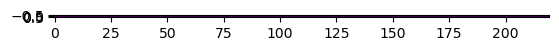

In [16]:
plt.imshow(noisy[0,0,:,:].cpu().detach().numpy())

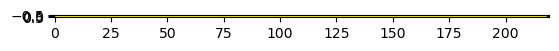

In [17]:
plt.imshow(output_train[0,0,:,:].cpu().detach().numpy())

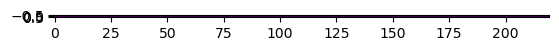

In [18]:
plt.imshow(noisefree[0,0,:,:].cpu().detach().numpy())

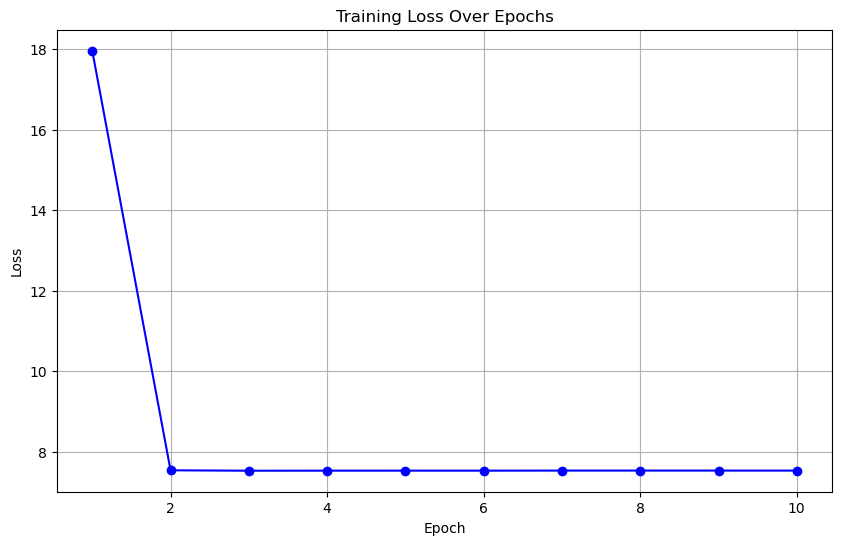

In [19]:
# Create an array for the x-axis values (epoch numbers)
epochs = list(range(1, len(loss_list) + 1))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_list, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')

# Optionally add a grid
plt.grid(True)

# Show the plot
plt.show()

In [29]:
# Load the test noisy and noisefree sinograms
test_sinograms_noisy = np.load('./PET_data/Test_npy/test_sinograms_noisy.npy')
test_sinograms_noisefree = np.load('./PET_data/Test_npy/test_sinograms_noisefree.npy')

# Convert the numpy arrays to PyTorch tensors
test_sinograms_noisy = torch.tensor(test_sinograms_noisy, dtype=torch.float32)
test_sinograms_noisefree = torch.tensor(test_sinograms_noisefree, dtype=torch.float32)

In [30]:
test_sinograms_noisy.shape

torch.Size([580, 1, 220, 220])

In [31]:
test_sinograms_noisy[0].permute(2, 0, 1).shape

torch.Size([220, 1, 220])

In [32]:
output_train.shape

torch.Size([220, 1, 1, 220])

In [33]:
# PSNR and SSIM Calculations for Sinograms in the test Set
model.eval() 

# Initialize lists for PSNR, SSIM, and RMSE
psnr_values = []
ssim_values = []
rmse_values = []


# Loop over all samples in the validation set
with torch.no_grad():
    for i in range(20):
        # Get the model input and target for the current sample
        test_sinograms_noisy_new = test_sinograms_noisy[i].permute(2, 0, 1)
        test_sinograms_noisefree_new = test_sinograms_noisefree[i].permute(2, 0, 1)

        model_input = to_device(test_sinograms_noisy_new, dev)
        target = to_device(test_sinograms_noisefree_new, dev)
        
        # Get the model output
        model_output = model(model_input.unsqueeze(1))
        
        # Calculate PSNR and SSIM for the current sample
        for j in range(35):
            psnr_value = fom.psnr(model_output[j,0,:,:].cpu().numpy(), target[j].cpu().numpy())
            ssim_value = fom.ssim(model_output[j,0,:,:].cpu().numpy(), target[j].cpu().numpy())
            rmse_value = np.sqrt(fom.mean_squared_error(model_output[j,0,:,:].cpu().numpy(), target[j].cpu().numpy()))
        
            # Append the values to the lists
            psnr_values.append(psnr_value)
            ssim_values.append(ssim_value)
            rmse_values.append(rmse_value)

# Convert lists to NumPy arrays for easy mean and std calculation
psnr_values = np.array(psnr_values)
ssim_values = np.array(ssim_values)
rmse_values = np.array(rmse_values)

# Calculate the mean and standard deviation
mean_psnr = np.mean(psnr_values)
std_psnr = np.std(psnr_values)

mean_ssim = np.mean(ssim_values)
std_ssim = np.std(ssim_values)

mean_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

# Print the mean and standard deviation for PSNR, SSIM, and RMSE
print("PSNR: {:.3f} ± {:.3f}".format(mean_psnr, std_psnr))
print("SSIM: {:.3f} ± {:.3f}".format(mean_ssim, std_ssim))
print("RMSE: {:.3f} ± {:.3f}".format(mean_rmse, std_rmse))

PSNR: -inf ± nan
SSIM: 0.637 ± 0.268
RMSE: 0.278 ± 0.158


In [34]:
model_output.shape

torch.Size([220, 1, 1, 220])

In [35]:
plt.imshow(np.abs(model_output[20,0,:,:].cpu().numpy()-target[20].cpu().numpy()))
#plt.colorbar()
ax = plt.gca()
ax.set_axis_off()
np.sum(np.abs(model_output[20,0,:,:].cpu().numpy()-target[20].cpu().numpy()))

30.854753

In [36]:
model_input.shape

torch.Size([220, 1, 220])

In [37]:
plt.imshow(np.abs(model_input[20].cpu().numpy()-target[20].cpu().numpy()))
#plt.colorbar()
ax = plt.gca()
ax.set_axis_off()
np.sum(np.abs(model_input[20].cpu().numpy()-target[20].cpu().numpy()))

42.637474

In [38]:
plt.imshow(np.abs(target[20].cpu().numpy()-target[20].cpu().numpy()))
#plt.colorbar()
ax = plt.gca()
ax.set_axis_off()

In [43]:
# Load the test attenuation images
test_images_att = np.load('./PET_data/Test_npy/test_images_att.npy')

# Convert the numpy arrays to PyTorch tensors
test_images_att = torch.tensor(test_images_att, dtype=torch.float32)


FileNotFoundError: [Errno 2] No such file or directory: './PET_data/Test_npy/test_images_att.npy'

In [40]:
test_images_att.shape

NameError: name 'test_images_att' is not defined

In [41]:
y_gpu = (test_images_att[19,:,:,:].permute(0,2,1)).to('cuda')

NameError: name 'test_images_att' is not defined

In [42]:
y_gpu.shape

NameError: name 'y_gpu' is not defined

In [32]:
# Incorporating image-based resolution model and adding the effect of attenuation

res_model = parallelproj.GaussianFilterOperator(
    proj.in_shape, sigma=0.75 / (2.35 * proj.voxel_size)
)
fa = proj(y_gpu)

att_sino = xp.exp(-fa)
att_op = parallelproj.ElementwiseMultiplicationOperator(att_sino)

proj_with_res_model = parallelproj.CompositeLinearOperator((att_op, proj, res_model))

In [ ]:
phi_max = xp.pi
num_rad = 111
num_phi = 210

r = xp.linspace(-55.5, 55.5, num_rad, device=dev, dtype=xp.float32)
n_filter = r.shape[0]
r_shift = torch.arange(n_filter, device=dev, dtype=torch.float64) - n_filter // 2
f = torch.zeros(n_filter, device=dev, dtype=torch.float64)
f[r_shift != 0] = -1 / (torch.pi**2 * r_shift[r_shift != 0] ** 2)
f[(r_shift % 2) == 0] = 0
f[r_shift == 0] = 0.25

fig, ax = plt.subplots(tight_layout=True)
ax.plot(r_shift.cpu().detach().numpy(), f.cpu().detach().numpy(), ".-")
ax.set_xlabel(r"$s$")
ax.set_ylabel(r"$f$")
ax.set_title("Ramp Filter", fontsize="medium")
fig.show()

In [34]:
x_fwd2 = target[20,:,:]

In [ ]:
x_fwd2.shape

In [36]:
pre_corrected_sino = x_fwd2.to('cuda')
filtered_pre_corrected_sino = 1.0 * pre_corrected_sino

for i in range(num_phi):
    filtered_pre_corrected_sino[:, i] = xp.asarray(
        np.convolve(
            parallelproj.to_numpy_array(filtered_pre_corrected_sino[:, i]),
            f.cpu(),
            mode="same",
        ),
        device=dev,
    )

In [ ]:
filtered_pre_corrected_sino.shape

In [38]:
fbp_reconstructed = proj_with_res_model.adjoint((filtered_pre_corrected_sino.unsqueeze(2)).repeat(1, 1, 35))

In [ ]:
fbp_reconstructed.shapes

In [ ]:
plt.imshow(fbp_reconstructed[:,0,:].cpu().detach().numpy())

In [41]:
x_fwd2 = model_input[20,:,:]

In [42]:
pre_corrected_sino = x_fwd2.to('cuda')
filtered_pre_corrected_sino = 1.0 * pre_corrected_sino

for i in range(num_phi):
    filtered_pre_corrected_sino[:, i] = xp.asarray(
        np.convolve(
            parallelproj.to_numpy_array(filtered_pre_corrected_sino[:, i]),
            f.cpu(),
            mode="same",
        ),
        device=dev,
    )

In [43]:
fbp_reconstructed = proj_with_res_model.adjoint((filtered_pre_corrected_sino.unsqueeze(2)).repeat(1, 1, 35))

In [ ]:
plt.imshow(fbp_reconstructed[:,0,:].cpu().detach().numpy())

In [45]:
x_fwd2 = model_output[20,0,:,:]

In [46]:
pre_corrected_sino = x_fwd2.to('cuda')
filtered_pre_corrected_sino = 1.0 * pre_corrected_sino

for i in range(num_phi):
    filtered_pre_corrected_sino[:, i] = xp.asarray(
        np.convolve(
            parallelproj.to_numpy_array(filtered_pre_corrected_sino[:, i]),
            f.cpu(),
            mode="same",
        ),
        device=dev,
    )

In [47]:
fbp_reconstructed = proj_with_res_model.adjoint((filtered_pre_corrected_sino.unsqueeze(2)).repeat(1, 1, 35))

In [ ]:
plt.imshow(fbp_reconstructed[:,0,:].cpu().detach().numpy())